# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab'
path.append(root)

context_data_location = '/data/data-with-embeddings/contextualized-embeddings/BERT-base-multilingual-cased'
non_context_data_location = '/data/data-with-embeddings/not-contextualized-embeddings/BERT-base-multilingual-cased'

processed_amazon_english_data_location = root + context_data_location + '/amazon_english.json'
processed_amazon_german_data_location = root + context_data_location + '/amazon_german.json'
processed_nc_amazon_german_data_location = root + non_context_data_location + '/amazon_german.json'
processed_nc_organic_data_location = root + non_context_data_location + '/organic.json'

embedding_dim = 768

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def read_data(processed_data_location):
  if processed_data_location is None:
    return None

  with open(processed_data_location) as json_file:      
      data_df = json_file.read() 
      data_df = json.loads(data_df)

  return pd.DataFrame(data_df)

In [19]:
amazon_en_df = read_data(processed_amazon_english_data_location)

In [20]:
amazon_de_df = read_data(processed_amazon_german_data_location)
nc_amazon_de_df = read_data(processed_nc_amazon_german_data_location)

In [21]:
nc_organic_df = read_data(processed_nc_organic_data_location)

In [22]:
def drop(df, column, value):
  print(f'----> size before {len(df)}')
  idx = df[column] != value
  print(f'----> size after {idx.sum()}')
  return df[idx]

drop_neutral = False

if drop_neutral:
  print('======DROPPING NEUTRAL CLASS======')
  print('amazon_en')
  amazon_en_df = drop(amazon_en_df, 'comment_sentiment', '0')
  print('amazon_de')
  amazon_de_df = drop(amazon_de_df, 'comment_sentiment', '0')
  print('amazon_de')
  nc_amazon_de_df = drop(nc_amazon_de_df, 'comment_sentiment', '0')
  print('nc_organic')
  nc_organic_df = drop(nc_organic_df, 'sentence_sentiment', '0')

In [23]:
if drop_neutral:
  sentiment_classes = {'n': 0, 'p': 1}
  sentiment_labels = {0 : 'n', 1 : 'p'} 
else:
  sentiment_classes = {'n': 0, '0': 1, 'p': 2}
  sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'} 

last_column = str(embedding_dim - 1)

def parse_amazon_data(df, downsampling_factor=1):
  if df is None:
    return dataset.DocumentDataset((), ()), ()

  comments = []
  sentiments = []

  for comment_id, comment_df in df.groupby('comment_id'):
    nunique_sentiments = comment_df['comment_sentiment'].nunique()
    if (nunique_sentiments > 1):
      print('Found inconsitent sentiment'
            f'for the comment with id = {comment_id}')

    sentiment = comment_df['comment_sentiment'][0]
    if sentiment == 'p' and random.random() > downsampling_factor:
      continue

    comments.append(torch.Tensor(comment_df.loc[:, '0':last_column].values).to(device))
    sentiments.append(sentiment_classes[sentiment])

  sentiment_dataset = dataset.DocumentDataset(comments, sentiments)
  sentiments = torch.Tensor(sentiments).to(device)

  return sentiment_dataset, sentiments

amazon_en_dataset, amazon_en_sentiments = parse_amazon_data(amazon_en_df, 0.15)
amazon_de_dataset, amazon_de_sentiments = parse_amazon_data(amazon_de_df)
nc_amazon_de_dataset, nc_amazon_de_sentiments = parse_amazon_data(nc_amazon_de_df)

In [24]:
nc_organic_embeddings = torch.Tensor(
    nc_organic_df.loc[:, '0':last_column].values).to(device)
nc_organic_sentiments = torch.Tensor(nc_organic_df['sentence_sentiment'].apply(
    lambda sentiment: sentiment_classes[sentiment])).to(device)
nc_organic_dataset = dataset.DocumentDataset(tuple(nc_organic_embeddings.unsqueeze(1)),
                                          nc_organic_sentiments)

In [25]:
datasets = {'amazon_en' : amazon_en_dataset, 'amazon_de': amazon_de_dataset,
            'nc_amazon_de': nc_amazon_de_dataset, 'nc_organic': nc_organic_dataset}

for label, dset in datasets.items():
  print(f'len({label}) = {len(dset)}')

len(amazon_en) = 4277
len(amazon_de) = 9897
len(nc_amazon_de) = 9897
len(nc_organic) = 5084


In [26]:
full_stats = amazon_en_df.groupby('comment_id')['comment_sentiment'].agg(
    pd.Series.mode).value_counts()
sentiments, counts = amazon_en_sentiments.unique(return_counts=True, sorted=True)
for sentiment, count in zip(sentiments, counts):
  label = sentiment_labels[sentiment.item()]
  print(f'sentiment "{label}":')
  print(f'\tbefore downsampling -> {full_stats[label]}; '
        f'after downsampling -> {count.item()}')

sentiment "n":
	before downsampling -> 1188; after downsampling -> 1188
sentiment "0":
	before downsampling -> 1325; after downsampling -> 1325
sentiment "p":
	before downsampling -> 11585; after downsampling -> 1764


In [ ]:
def split(dataset_to_split, splits=(0.8, 0.1, 0.1)):
  assert(sum(splits) == 1)
  n_comments = len(dataset_to_split)
  n_val = int(splits[1] * n_comments)
  n_test = int(splits[2] * n_comments)
  n_train = n_comments - n_val - n_test

  return utils.data.random_split(dataset_to_split, (n_train, n_val, n_test))

amazon_en_train, amazon_en_val, amazon_en_test = split(amazon_en_dataset)
nc_organic_train, nc_organic_val, nc_organic_test = split(nc_organic_dataset)

In [27]:
prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

params = model.MilNetParams()

params.seg_emb_dim =  embedding_dim
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.5
params.dropout_att = 0.5
params.dropout_seg = 0.5
params.classes_nb = 3 - drop_neutral

milnet = model.MilNet(params, train_embeddings=False).to(device)

In [ ]:
def train(model, train_set, val_set):
  train_loader = utils.data.DataLoader(train_set, batch_size=128,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)
  val_loader = utils.data.DataLoader(val_set, batch_size=128,
                                      shuffle=True,
                                      collate_fn=prepare_batch,
                                      drop_last=True)

  dataloaders = {'train': train_loader, 'val': val_loader}

  optimizer = optim.Adam(model.parameters(), lr=5e-3, weight_decay=1e-2)
  criterion = nn.NLLLoss()

  nb_epochs = 200
  patience = 50

  return trainer.fit(model, optimizer, criterion, dataloaders, nb_epochs,
                     patience, print_every=10)

print("=====TRAIN ON AMAZON DATA=====")
_, amazon_en_train_losses, amazon_en_val_losses = train(milnet,
                                                        amazon_en_train,
                                                        amazon_en_val)

torch.save(milnet.state_dict(), root + f'/models/milnet/state_dicts/bert_context_ml_no_finetune_{params.classes_nb}cl')

print("=====FINETUNE ON ORGANIC DATA=====")
_, organic_train_losses, organic_val_losses = train(milnet, nc_organic_train,
                                                    nc_organic_val)

=====TRAIN ON AMAZON DATA=====
Epoch  10/200 -> train loss: 4.04e-03, accuracy: 73.03%
Epoch  10/200 -> val loss: 3.19e-03, accuracy: 69.28%
Epoch  20/200 -> train loss: 3.74e-03, accuracy: 77.29%
Epoch  20/200 -> val loss: 3.60e-03, accuracy: 60.41%
Epoch  30/200 -> train loss: 3.81e-03, accuracy: 76.78%
Epoch  30/200 -> val loss: 3.06e-03, accuracy: 67.92%
Epoch  40/200 -> train loss: 3.60e-03, accuracy: 79.46%
Epoch  40/200 -> val loss: 3.20e-03, accuracy: 69.28%
Epoch  50/200 -> train loss: 3.89e-03, accuracy: 74.18%
Epoch  50/200 -> val loss: 3.17e-03, accuracy: 67.58%
Epoch  60/200 -> train loss: 3.54e-03, accuracy: 79.07%
Epoch  60/200 -> val loss: 3.01e-03, accuracy: 68.94%
Epoch  70/200 -> train loss: 3.57e-03, accuracy: 79.07%
Epoch  70/200 -> val loss: 3.40e-03, accuracy: 63.48%
Epoch  80/200 -> train loss: 3.69e-03, accuracy: 76.95%
Epoch  80/200 -> val loss: 3.03e-03, accuracy: 69.28%
Epoch  90/200 -> train loss: 3.61e-03, accuracy: 77.92%
Epoch  90/200 -> val loss: 3.00e-

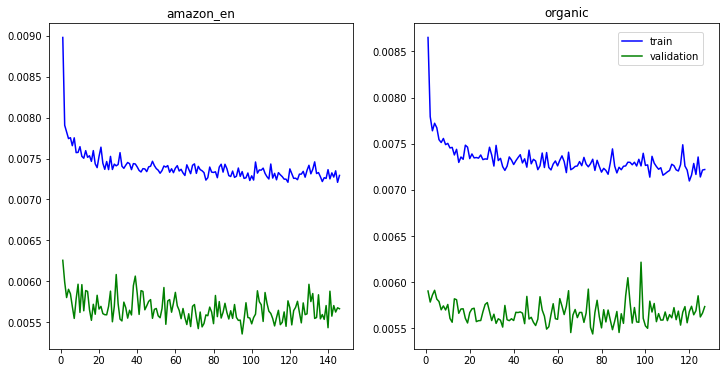

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(title, ax, train_losses, val_losses):
  epochs = np.arange(1, len(train_losses) + 1)
  ax.set_title(title)
  ax.plot(epochs, train_losses, color='blue', label='train')
  ax.plot(epochs, val_losses, color='green', label='validation')


fig, (ax_amazon_en, ax_organic) = plt.subplots(1, 2, figsize=(12,6))
plot_losses("amazon_en", ax_amazon_en, amazon_en_train_losses,
            amazon_en_val_losses)
plot_losses("organic", ax_organic, organic_train_losses, organic_val_losses)

handles, labels = ax_organic.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.82, 0.8))

fig.show()

In [ ]:
torch.save(milnet.state_dict(), root + f'/models/milnet/state_dicts/bert_context_ml_{params.classes_nb}cl')

<All keys matched successfully>

In [34]:
milnet = model.MilNet(params, train_embeddings=False).to(device)
milnet.load_state_dict(torch.load(root + f'/models/milnet/state_dicts/bert_context_ml_no_finetune_{params.classes_nb}cl'))

<All keys matched successfully>

In [35]:
def get_results(full_set, nb_runs):
  results = []
  n = len(full_set)
  for _ in range(nb_runs):
    _, test_set = utils.data.random_split(full_set, [n - n //10, n//10])
    test_loader = utils.data.DataLoader(test_set, batch_size=len(test_set),
                                        shuffle=True,
                                        collate_fn=prepare_batch,
                                        drop_last=True)
    for documents, classes in test_loader:
      predictions = milnet(documents).cpu().numpy()
      results.append((np.argmax(predictions, axis=1), classes.cpu().numpy()))
  
  return results

results = {}
nb_runs = 40


milnet.eval()
with torch.set_grad_enabled(False):
  for name, full_set in datasets.items():
    results[name] = get_results(full_set, nb_runs)

In [36]:
for dataset_name, run_result in results.items():
  worst_f1 = float('inf')
  mean_f1 = 0
  top1 = None
  labels = None
  for run_top1, run_labels in run_result:
    run_micro = metrics.f1_score(run_labels, run_top1, average="micro")
    run_macro = metrics.f1_score(run_labels, run_top1, average="macro")
    run_f1 = run_micro + run_macro

    mean_f1 += run_f1

    if run_f1 < worst_f1:
      worst_f1 = run_f1
      top1 = run_top1
      labels = run_labels

  print(f'=== {dataset_name} ===')
  print(f'mean F1-score = {mean_f1/nb_runs/2}, worst F1-score = {worst_f1/2}')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== amazon_en ===
mean F1-score = 0.6130566197956262, worst F1-score = 0.5546358237479181
F1-micro = 0.5644028103044496
F1-macro = 0.5448688371913867

         n    0    p
    n   49   57   24
    0   24   69   32
    p   15   34  123

=== amazon_de ===
mean F1-score = 0.5265721710480941, worst F1-score = 0.5002788379331716
F1-micro = 0.5187057633973711
F1-macro = 0.48185191246897224

         n    0    p
    n  173   94  130
    0   59   65   85
    p   38   70  275

=== nc_amazon_de ===
mean F1-score = 0.5287171230047245, worst F1-score = 0.5048074866953859
F1-micro = 0.5156723963599595
F1-macro = 0.4939425770308123

         n    0    p
    n  171   97  127
    0   53   87   86
    p   46   70  252

=== nc_organic ===
mean F1-score = 0.41964388054943447, worst F1-score = 0.37406678243721436
F1-micro = 0.37598425196850394
F1-macro = 0.37214931290592485

         n    0    p
    n   48   58   41
    0   48   58   97
    p   35   38   85

